# Vector Compression Techniques with Azure AI Search

This Jupyter Notebook serves as a comprehensive tool for benchmarking various vector compression techniques in the context of Azure AI Search. As organizations increasingly rely on vector search for efficient retrieval of high-dimensional data, optimizing storage and query performance becomes critical. This notebook provides an end-to-end framework to evaluate compression algorithms—such as quantization, dimensionality reduction, and sparse representations—by comparing their impact on key metrics like retrieval accuracy, latency, and storage efficiency. Leveraging Azure AI Search's robust capabilities, the notebook enables users to upload, compress, and index vector datasets, perform search queries, and visualize the trade-offs between performance and compression levels. Ideal for data scientists and AI practitioners, this resource facilitates data-driven decisions in selecting the best compression strategy tailored to specific use cases.

In [83]:
import sys
sys.path.append(".")


import os
from dotenv import load_dotenv
import pandas as pd
from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential
import json
import time
import numpy as np
from azure.search.documents.indexes import SearchIndexClient
from indexes import indexes_config
from matplotlib import pyplot as plt
from tqdm import tqdm

# Load environment variables from .env file
load_dotenv(override=True)
%load_ext autoreload
%autoreload 2

# Load environment variables from .env file
search_service_endpoint = os.environ["AZURE_SEARCH_ENDPOINT"]
search_service_key = os.environ["AZURE_SEARCH_KEY"]
azure_openai_endpoint = os.environ["AZURE_OPENAI_ENDPOINT"]
azure_openai_key = os.getenv("AZURE_OPENAI_KEY")
azure_openai_gpt_deployment = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT", "gpt-4o")
azure_openai_embedding_deployment = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT", "text-embedding-3-large")
azure_openai_embedding_dimensions = int(os.getenv("AZURE_OPENAI_EMBEDDING_DIMENSIONS", 3072))
embedding_model_name = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT", "text-embedding-3-large")
azure_openai_api_version = os.getenv("AZURE_OPENAI_API_VERSION", "2024-06-01")
use_hybrid_search = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
search_index_client = SearchIndexClient(
search_service_endpoint, AzureKeyCredential(search_service_key))

In [85]:
from data_pipeline import get_embeddings
if os.path.exists("search_queries.csv"):
    df_search_queries = pd.read_csv("search_queries.csv")
else:
    # this may take a while
    search_queries = json.load(open("test_data.json"))["data"]
    df_search_queries = pd.DataFrame(search_queries, columns=["search_query"])
    df_search_queries["embedding"] = df_search_queries["search_query"].apply(lambda x: get_embeddings(x))
    df_search_queries.to_csv("search_queries.csv", index=False)
df_search_queries.head()

,search_query,embedding
0,What is the main plot of the first Harry Potte...,"[0.015947405248880386, -0.05834364891052246, 0..."
1,Who are the main characters in Harry Potter an...,"[-7.944405660964549e-05, -0.015836382284760475..."
2,What is the significance of the Sorting Hat in...,"[0.018047716468572617, -0.04168352112174034, -..."
3,How does Harry Potter discover he is a wizard?,"[0.0028701741248369217, -0.0003465288027655333..."
4,What are the key differences between the book ...,"[0.01255048904567957, -0.03629925847053528, -0..."


In [86]:
indexes = list(indexes_config.keys())
print(f"The following indexes are available: {indexes}")

The following indexes are available: ['baseline', 'binary-compression', 'no-stored', 'all-options-with-scalar', 'all-options-with-binary', 'scalar-oversampling-reranking', 'scalar-truncation', 'hf_embeddings', 'py_embeddings_scalar', 'py_embeddings_binary']


In [109]:
def bytes_to_kb(bytes):
    return round(bytes / 1024, 4)

def bytes_to_mb(bytes):
    return round(bytes / (1024 * 1024), 4)

def find_storage_size_kb(index_name):
    response = search_index_client.get_index_statistics(index_name)
    return bytes_to_kb(response["storage_size"]), bytes_to_kb(response["vector_index_size"])

index_sizes = [(find_storage_size_kb(index), index) for index in indexes]
# index_sizes.sort(key=lambda item: item[0][0], reverse=True)

data = []
for ((storage_size, vector_size), index_name) in index_sizes:
    data.append({"Storage Size": storage_size, "Vector Size": vector_size, "Index Name": index_name})

In [110]:
def format_percentage_with_arrow(percentage):
    if percentage > 0:
        return f"{percentage:.2f}% ▲"
    elif percentage < 0:
        return f"{percentage:.2f}% ▼"
    else:
        return f"{percentage:.2f}%"

df_summary = pd.DataFrame(data)
# Calculate the reduction in storage size compared to baseline
baseline_storage_size = df_summary.iloc[0]["Storage Size"]
baseline_vector_size = df_summary.iloc[0]["Vector Size"]
df_summary["% Impact on Storage"] = 100 * (baseline_storage_size-df_summary["Storage Size"]) / df_summary["Storage Size"]
df_summary["% Impact on Vector Size"] = 100 * (baseline_vector_size - df_summary["Vector Size"]) / df_summary["Vector Size"]
df_summary["% Impact on Storage"] = df_summary["% Impact on Storage"].apply(format_percentage_with_arrow)
df_summary["% Impact on Vector Size"] = df_summary["% Impact on Vector Size"].apply(format_percentage_with_arrow)

This table compares different vector compression techniques, highlighting their impact on storage and vector sizes. Here's a breakdown of its structure:

1. **Columns:**
   - **Storage Size:** Indicates the storage space (in some unit) consumed by the vectors after applying a particular compression method.
   - **Vector Size:** Represents the size of individual vectors after compression.
   - **Index Name:** Names of the compression methods or configurations being benchmarked (e.g., "baseline," "scalar-compression").
   - **% Reduction in Storage:** The percentage decrease in storage size compared to the baseline.
   - **% Reduction in Vector Size:** The percentage decrease in vector size compared to the baseline.

2. **Rows:**
   - Each row represents a specific compression method or configuration. 
   - The "baseline" row (row 0) provides a reference point with no compression applied, against which all other methods are compared.

3. **Observations:**
   - Some methods, like "binary-compression," achieve significant reductions in vector size.
   - "scalar-compression" increases storage slightly (8.08%) while keeping vector size unchanged.
   - "py_embeddings_binary" achieves the highest percentage reduction in storage (36.45%) with moderate vector size reduction.

This table provides a clear comparison of trade-offs between storage efficiency and vector size reduction for various compression strategies. In the following sections we will compare the search scores, latency for each of the indexes.

In [111]:
print(f"Summary of Index Sizes in KB")
df_summary.head(15)

Summary of Index Sizes in KB


,Storage Size,Vector Size,Index Name,% Impact on Storage,% Impact on Vector Size
0,3400.9199,302.5000,baseline,0.00%,0.00%
1,3412.5938,11.8750,binary-compression,-0.34% ▼,2447.37% ▲
2,2748.5498,302.5000,no-stored,23.74% ▲,0.00%
3,2751.7832,152.5000,all-options-with-scalar,23.59% ▲,98.36% ▲
4,2610.2666,11.8750,all-options-with-binary,30.29% ▲,2447.37% ▲
5,2751.7832,152.5000,scalar-oversampling-reranking,23.59% ▲,98.36% ▲
6,2751.7832,152.5000,scalar-truncation,23.59% ▲,98.36% ▲
7,2563.9229,40.0195,hf_embeddings,32.65% ▲,655.88% ▲
8,2470.5879,11.8945,py_embeddings_scalar,37.66% ▲,2443.19% ▲
9,2412.6826,11.7578,py_embeddings_binary,40.96% ▲,2472.76% ▲


The following images compares `Storage Size` across different vector compression techniques

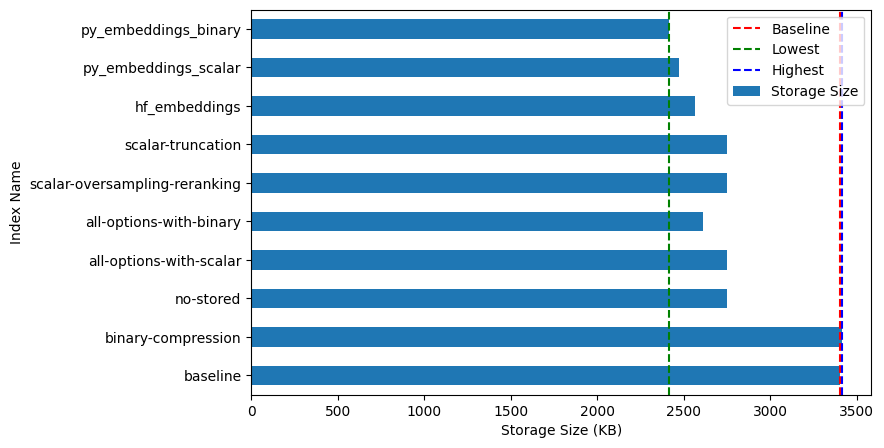

In [112]:
# show the storage size and vector size of the indexes by index name
df_summary.plot(x="Index Name", y=["Storage Size"], kind="barh", figsize=(8, 5))
plt.axvline(baseline_storage_size, color="red", linestyle="--", label="Baseline")
plt.axvline(df_summary["Storage Size"].min(), color="green", linestyle="--", label="Lowest")
plt.axvline(df_summary["Storage Size"].max(), color="blue", linestyle="--", label="Highest")
plt.xlabel("Storage Size (KB)")
plt.legend()

The following images compares `Vector Size` across different vector compression techniques

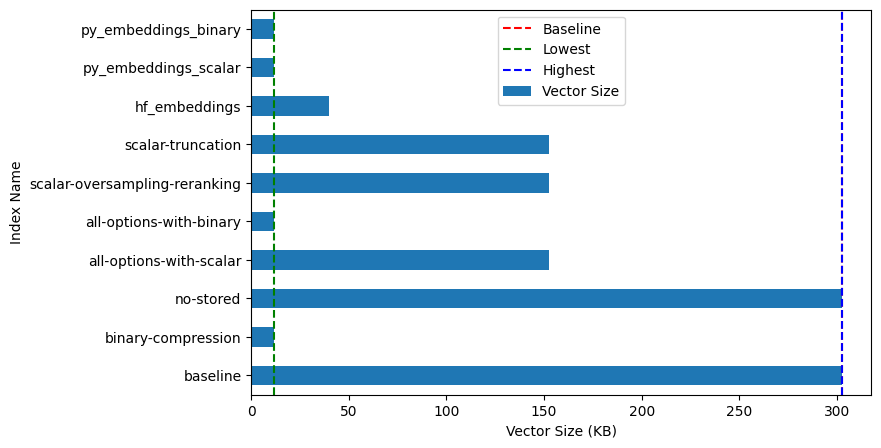

In [113]:
# show the storage size and vector size of the indexes by index name
df_summary.plot(x="Index Name", y=["Vector Size"], kind="barh", figsize=(8, 5))
plt.axvline(baseline_vector_size, color="red", linestyle="--", label="Baseline")
plt.axvline(df_summary["Vector Size"].min(), color="green", linestyle="--", label="Lowest")
plt.axvline(df_summary["Vector Size"].max(), color="blue", linestyle="--", label="Highest")
plt.xlabel("Vector Size (KB)")
plt.legend()

In [114]:
import concurrent.futures
from azure.search.documents.models import VectorizedQuery

def hybrid_search(search_client, query, embedding):
    start = time.time()
    vector_query = VectorizedQuery(vector=embedding, fields="embedding", k_nearest_neighbors=3)
    results = search_client.search(search_text=query, 
                                   vector_queries=[vector_query],
                                   select=["content_vector", "content"],
                                   top=1)
    text = ""
    for res in results:
        text, score = res["content"], res["@search.score"]
    end = time.time()
    return text, float(score), float(end-start)

def search_docs(search_client, search_text):
    search_text = search_text.replace("\"", "")
    start = time.time()
    results = search_client.search(search_text=search_text, top=1)
    text = ""
    for res in results:
        text, score = res["content"], res["@search.score"]
    end = time.time()
    return text, float(score), float(end-start)

def perform_search(index, number_of_trials, search_queries):
    results = []
    search_client = SearchClient(endpoint=search_service_endpoint, index_name=index, credential=AzureKeyCredential(search_service_key))
    for _ in range(number_of_trials):
        random = np.random.randint(0, len(search_queries))
        # get random row from python dataframe
        row = search_queries.iloc[random]
        search_text = row["search_query"] if not use_hybrid_search else row["embedding"]
        text, score, tt = search_docs(search_client, search_text) if not use_hybrid_search else hybrid_search(search_client, search_text)
        results.append({"search_text": search_text, "search_results_text": text, "search_results_score": score, "search_results_time": tt, "index": index})
    return results

# Test the search performance of the indexes
# search_client = SearchClient(endpoint=search_service_endpoint, index_name=indexes[0], credential=AzureKeyCredential(search_service_key))
# result = hybrid_search(search_client, df_search_queries.iloc[0]["search_query"], df_search_queries.iloc[0]["embedding"])

In [115]:
pd.DataFrame()
number_of_trials = 10
# Run in parallel
all_results = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    future_to_index = {executor.submit(perform_search, index, number_of_trials, df_search_queries): index for index in indexes}
    for future in tqdm(concurrent.futures.as_completed(future_to_index), total=len(indexes)):
        all_results.extend(future.result())

# Convert to DataFrame
results_df = pd.DataFrame(all_results)
results_df.head()

100%|██████████| 10/10 [00:00<00:00, 14.16it/s]


,search_text,search_results_text,search_results_score,search_results_time,index
0,What is the significance of the Sorting Hat in...,And something was stirring inside the statue’...,5.528351,0.134672,hf_embeddings
1,How does J.K. Rowling develop the magical worl...,Harry Potter and the Chamber of Secrets by J...,6.086375,0.083863,hf_embeddings
2,What is the main plot of the first Harry Potte...,"d live many hundreds of years, is born from a ...",4.860774,0.057365,hf_embeddings
3,How does J.K. Rowling develop the magical worl...,Harry Potter and the Chamber of Secrets by J...,6.086375,0.051661,hf_embeddings
4,Who are the main characters in Harry Potter an...,h the school so alert and suspicious. Perhaps ...,4.968647,0.039246,hf_embeddings


Text(0.5, 0, 'Search Time (s)')

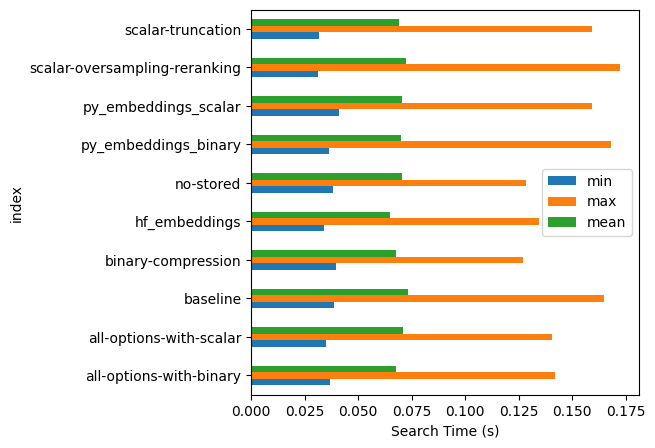

In [116]:
results_df.groupby("index")["search_results_time"].agg(["min", "max", "mean"]).plot(kind="barh", figsize=(5, 5))
plt.xlabel("Search Time (s)")

Text(0.5, 0, 'Search Score (s)')

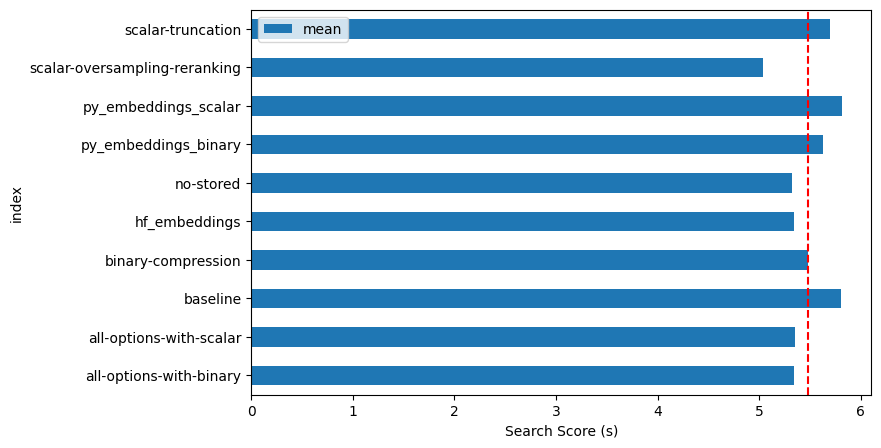

In [117]:
results_df.groupby("index")["search_results_score"].agg(["mean"]).plot(kind="barh", figsize=(8, 5))
# highest score is the best
plt.axvline(results_df["search_results_score"].mean(), color="red", linestyle="--", label="Highest")
plt.xlabel("Search Score (s)")

#### Summary

This table summarizes data about various compression methods for Azure AI search system. Here's a breakdown of each column:

1. **Storage Size**: The amount of storage space (in some unit) required for each indexing method.
2. **Vector Size**: The size of the vectors used in the index, which affects performance.
3. **Index Name**: The name of each indexing method or configuration.
4. **% Reduction in Storage**: How much the storage size is reduced compared to a baseline index.
5. **% Reduction in Vector Size**: The percentage reduction in vector size relative to the baseline.
6. **Average Search Time (s)**: The time it takes, on average, to perform a search using the index.
7. **Average Search Score**: A measure of the search quality or relevance for each method.

Each row corresponds to a different indexing approach or configuration with its respective metrics. Let me know if you need more specific insights!

In [118]:
# for each index in df_summary, calculate the average search time
df_summary["Average Search Time (s)"] = 0.0
df_summary["Average Search Score"] = 0.0
for index in indexes:
    df_summary.loc[df_summary["Index Name"] == index, "Average Search Time (s)"] = results_df[results_df["index"] == index]["search_results_time"].mean()
    df_summary.loc[df_summary["Index Name"] == index, "Average Search Score"] = results_df[results_df["index"] == index]["search_results_score"].mean()
df_summary.head(15)

,Storage Size,Vector Size,Index Name,% Impact on Storage,% Impact on Vector Size,Average Search Time (s),Average Search Score
0,3400.9199,302.5000,baseline,0.00%,0.00%,0.073193,5.802669
1,3412.5938,11.8750,binary-compression,-0.34% ▼,2447.37% ▲,0.067444,5.479728
2,2748.5498,302.5000,no-stored,23.74% ▲,0.00%,0.070273,5.324842
3,2751.7832,152.5000,all-options-with-scalar,23.59% ▲,98.36% ▲,0.070858,5.353785
4,2610.2666,11.8750,all-options-with-binary,30.29% ▲,2447.37% ▲,0.067570,5.344018
5,2751.7832,152.5000,scalar-oversampling-reranking,23.59% ▲,98.36% ▲,0.072175,5.037520
6,2751.7832,152.5000,scalar-truncation,23.59% ▲,98.36% ▲,0.068992,5.696125
7,2563.9229,40.0195,hf_embeddings,32.65% ▲,655.88% ▲,0.064940,5.345249
8,2470.5879,11.8945,py_embeddings_scalar,37.66% ▲,2443.19% ▲,0.070641,5.813660
9,2412.6826,11.7578,py_embeddings_binary,40.96% ▲,2472.76% ▲,0.070037,5.624548


#### Mercury with your notebooks

To run Mercury with your notebook, please execute the following:

```
mercury run
```

Mercury is used to turn this Python Notebook into a interactive Web App. You can change code in Jupyter Notebook, and Mercury will instantly update web app. <br/>
Please check http://127.0.0.1:8000 to see demo notebooks.



In [121]:
import mercury as mr
app = mr.App(title="Vector Compression Techniques with Azure AI Search", description="Compare the performance of different vector compression techniques with Azure AI Search")
selected_indexes = mr.MultiSelect(label="Please select Indexes for comparison", 
                          value=["baseline", "binary-compression"], 
                          choices=indexes)

metrics = ["Storage Size", "Vector Size", "% Reduction in Storage", "% Reduction in Vector Size", "Average Search Time (s)", "Average Search Score"]

selected_metrics = mr.MultiSelect(label="Please select Metrics for comparison", 
                          value=["Average Search Time (s)"], 
                          choices=metrics)

mercury.App

mercury.MultiSelect

mercury.MultiSelect

['Average Search Time (s)']
['baseline', 'binary-compression']


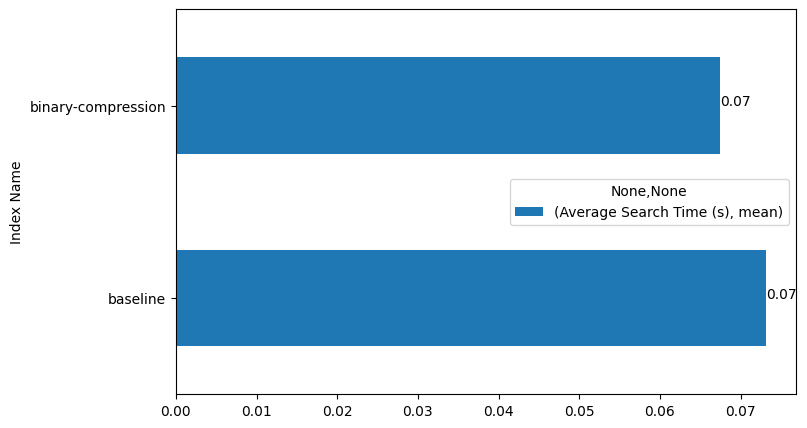

In [122]:

print(selected_metrics.value)
print(selected_indexes.value)
# filter by selected indexes
df_summary_filtered = df_summary[df_summary["Index Name"].isin(selected_indexes.value)]
df_summary_filtered.groupby("Index Name")[selected_metrics.value].agg(["mean"]).plot(kind="barh", figsize=(8, 5))
# show values on the bars
for index, row in df_summary_filtered.iterrows():
    for metric in selected_metrics.value:
        plt.text(row[metric], index, round(row[metric], 2))

#### Response Relevance with RAG

The following section calculates the `response relevance` scores, when the retrieved context from each of the indexes is used to perform RAG.
The ResponseRelevancy metric measures how relevant a response is to the user input. Higher scores indicate better alignment with the user input, while lower scores are given if the response is incomplete or includes redundant information.

In [ ]:
from langchain_openai import AzureChatOpenAI
from langchain import hub
from langchain.chains import RetrievalQA
from langchain.retrievers.azure_ai_search import AzureAISearchRetriever
from langchain.retrievers.azure_ai_search import AzureAISearchRetriever
from langchain_openai import AzureChatOpenAI
from langchain.chains import RetrievalQA
from langchain import hub

prompt = hub.pull("rlm/rag-prompt", api_url="https://api.hub.langchain.com")

def query_index(index_name: str, query: str):
    retriever = AzureAISearchRetriever(
        service_name=search_service_endpoint,
        api_key=search_service_key,
        index_name=index_name,
        content_key="content",
        top_k=2
    )

    chat_llm = AzureChatOpenAI(
        openai_api_version="2024-05-01-preview",
        api_key=azure_openai_key,
        azure_endpoint=azure_openai_endpoint,
        azure_deployment=azure_openai_gpt_deployment,
        temperature=0.0,
    )

    qa = RetrievalQA.from_chain_type(
        llm=chat_llm,
        chain_type="stuff",
        retriever=retriever,
        return_source_documents=True,
        chain_type_kwargs={
            "prompt": prompt,
        },
    )

    response = qa.invoke({"query": query})
    return response['result']

answers = []
query = "Who are the main characters in Harry Potter and the Philosopher's Stone?"
for index in indexes:
    answers.append({"index": index, "query": query, "answer": query_index(index, query)})
df = pd.DataFrame(answers)

c:\code\techconnect2025\vector-opt-ai-search\.venv\Lib\site-packages\langsmith\client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [132]:
pd.set_option('display.max_colwidth', None)
df.head(15)

,index,query,answer
0,baseline,Who are the main characters in Harry Potter and the Philosopher's Stone?,"The main characters in ""Harry Potter and the Philosopher's Stone"" are Harry Potter, Hermione Granger, and Ron Weasley."
1,binary-compression,Who are the main characters in Harry Potter and the Philosopher's Stone?,"The main characters in ""Harry Potter and the Philosopher's Stone"" are Harry Potter, Hermione Granger, and Ron Weasley."
2,no-stored,Who are the main characters in Harry Potter and the Philosopher's Stone?,"The main characters in ""Harry Potter and the Philosopher's Stone"" are Harry Potter, Hermione Granger, and Ron Weasley."
3,all-options-with-scalar,Who are the main characters in Harry Potter and the Philosopher's Stone?,"The main characters in ""Harry Potter and the Philosopher's Stone"" are Harry Potter, Hermione Granger, and Ron Weasley."
4,all-options-with-binary,Who are the main characters in Harry Potter and the Philosopher's Stone?,"The main characters in ""Harry Potter and the Philosopher's Stone"" are Harry Potter, Hermione Granger, and Ron Weasley."
5,scalar-oversampling-reranking,Who are the main characters in Harry Potter and the Philosopher's Stone?,"The main characters in ""Harry Potter and the Philosopher's Stone"" are Harry Potter, Hermione Granger, and Ron Weasley."
6,scalar-truncation,Who are the main characters in Harry Potter and the Philosopher's Stone?,"The main characters in ""Harry Potter and the Philosopher's Stone"" are Harry Potter, Hermione Granger, and Ron Weasley."
7,hf_embeddings,Who are the main characters in Harry Potter and the Philosopher's Stone?,"The main characters in ""Harry Potter and the Philosopher's Stone"" are Harry Potter, Hermione Granger, and Ron Weasley."
8,py_embeddings_scalar,Who are the main characters in Harry Potter and the Philosopher's Stone?,"The main characters in ""Harry Potter and the Philosopher's Stone"" are Harry Potter, Hermione Granger, and Ron Weasley."
9,py_embeddings_binary,Who are the main characters in Harry Potter and the Philosopher's Stone?,"The main characters in ""Harry Potter and the Philosopher's Stone"" are Harry Potter, Hermione Granger, and Ron Weasley."
